## Проект 4. Авиарейсы без потерь
### Юнит 5. Работа с базами данных. SQL 
#### Итоговая работа Анны Лубневской
#### DSPR-19

In [103]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import os

import re
import datetime
from datetime import datetime, timedelta

In [163]:
flight = pd.read_csv('flights.csv')
flight.sample(4)

,flight_id,sched_year,sched_month,sched_day,departure_airport,flight_no,arrival_airport,scheduled_departure,scheduled_arrival,delay_departure,...,flights_range_km,class2,ticket_count2,amount_sold2,avg_price_class2,class1,ticket_count1,amount_sold1,avg_price_class1,total_amount
109,136511,2017,2,21,AAQ,PG0194,NOZ,2017-02-21 09:10:00,2017-02-21 14:15:00,00:05:00,...,4200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,136815,2017,2,19,AAQ,PG0480,EGO,2017-02-19 12:25:00,2017-02-19 13:15:00,00:01:00,...,3000,Economy,85.0,538500.0,6335.0,Business,12.0,226800.0,18900.0,765300.0
66,136181,2017,1,31,AAQ,PG0252,SVO,2017-01-31 13:05:00,2017-01-31 14:45:00,00:00:00,...,4200,Economy,108.0,1323600.0,12256.0,Business,10.0,366000.0,36600.0,1689600.0
106,136320,2017,2,19,AAQ,PG0252,SVO,2017-02-19 13:05:00,2017-02-19 14:45:00,00:00:00,...,4200,Economy,96.0,1178400.0,12275.0,Business,10.0,366000.0,36600.0,1544400.0


In [164]:
flight.columns

Index(['flight_id', 'sched_year', 'sched_month', 'sched_day',
       'departure_airport', 'flight_no', 'arrival_airport',
       'scheduled_departure', 'scheduled_arrival', 'delay_departure', 'status',
       'flight_duration', 'city', 'timezone', 'actual_departure',
       'actual_arrival', 'delay_arrival', 'aircraft_code', 'manufacturer',
       'board_model', 'flights_range_km', 'class2', 'ticket_count2',
       'amount_sold2', 'avg_price_class2', 'class1', 'ticket_count1',
       'amount_sold1', 'avg_price_class1', 'total_amount'],
      dtype='object')

In [165]:
len(flight.columns)

30

In [166]:
# посмотрим на количество направлений
flight['city'].value_counts()

Moscow          59
Belgorod        59
Novokuznetsk     9
Name: city, dtype: int64

In [167]:
# продолжительность полетов
flight['flight_duration'].value_counts().sort_values(ascending=False)

00:50:00    34
01:40:00    27
01:39:00    17
00:51:00    15
00:49:00    10
01:41:00     8
01:38:00     4
01:42:00     2
05:10:00     2
05:04:00     1
04:59:00     1
05:11:00     1
05:07:00     1
01:43:00     1
05:02:00     1
05:05:00     1
05:12:00     1
Name: flight_duration, dtype: int64

In [168]:
# модель саомлетов
flight['board_model'].value_counts()

737-300         68
Superjet-100    59
Name: board_model, dtype: int64

In [169]:
# количество уникальных рейсов
flight['flight_no'].value_counts()

PG0252    59
PG0480    59
PG0194     9
Name: flight_no, dtype: int64

In [170]:
# количество мест в самолете по классам обслуживания
cabin_size = {'SU9': {'Economy': 85, 'Business':12 },
              '733': {'Economy': 118, 'Business':12 }}

Рассчитаем расход топлива и стоимость. Для этого посмотрим на цены на 2017 год на сайте [Федерального агенства воздушного транспорта](https://favt.gov.ru/dejatelnost-ajeroporty-i-ajerodromy-ceny-na-aviagsm-statistika-aviagsm/?id=3241).   
Предположим, что все заправки осуществлялись  Анапе. Итого имеем:

*  январь: 41435 руб\тонна
*  февраль: 39553 руб\тонна
*  декабрь: 47101 руб\тонна

In [171]:
# расход топлива за 1 час полета в кг
fuel_consumption = {'SU9': 1.7, '733': 2.4}

In [172]:
# стоимость топлива за 1000 кг
fuel_cost_2017 = {12: 47101, 1: 41435, 2: 39553}

In [173]:
flight['flight_hour'] = flight['flight_duration'].apply(lambda x: re.findall(r"\d+", str(x)))
flight['flight_hour'] = flight['flight_hour'].apply(lambda x: round(float(x[0]) + float(x[1])/60, 3))

In [174]:
# Далее заполняем пропуски
flight.fillna(0, inplace=True)

In [175]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            127 non-null    int64  
 1   sched_year           127 non-null    int64  
 2   sched_month          127 non-null    int64  
 3   sched_day            127 non-null    int64  
 4   departure_airport    127 non-null    object 
 5   flight_no            127 non-null    object 
 6   arrival_airport      127 non-null    object 
 7   scheduled_departure  127 non-null    object 
 8   scheduled_arrival    127 non-null    object 
 9   delay_departure      127 non-null    object 
 10  status               127 non-null    object 
 11  flight_duration      127 non-null    object 
 12  city                 127 non-null    object 
 13  timezone             127 non-null    object 
 14  actual_departure     127 non-null    object 
 15  actual_arrival       127 non-null    obj

In [176]:
flight['flight_costs'] = flight.apply(lambda row: row['flight_hour'] 
                                      * fuel_cost_2017[row['sched_month']] 
                                      * fuel_consumption[row['aircraft_code']], axis=1 )

In [177]:
flight['flight_profit'] = flight['total_amount'] - flight['flight_costs']

flight['flight_profit'] = flight['flight_profit'].apply(lambda x: int(x))

flight['total_amount'] = flight['total_amount'].apply(lambda x: int(x))

flight['flight_profit'] = flight['flight_profit'].apply(lambda x: int(x))

In [178]:
flight.columns

Index(['flight_id', 'sched_year', 'sched_month', 'sched_day',
       'departure_airport', 'flight_no', 'arrival_airport',
       'scheduled_departure', 'scheduled_arrival', 'delay_departure', 'status',
       'flight_duration', 'city', 'timezone', 'actual_departure',
       'actual_arrival', 'delay_arrival', 'aircraft_code', 'manufacturer',
       'board_model', 'flights_range_km', 'class2', 'ticket_count2',
       'amount_sold2', 'avg_price_class2', 'class1', 'ticket_count1',
       'amount_sold1', 'avg_price_class1', 'total_amount', 'flight_hour',
       'flight_costs', 'flight_profit'],
      dtype='object')

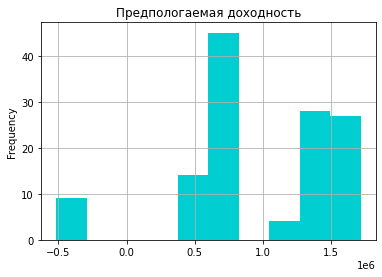

In [212]:
flight['flight_profit'].plot(kind='hist', grid=True, title='Предпологаемая доходность', color = '#00CED1')

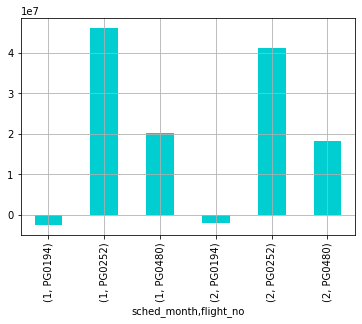

In [213]:
flight.groupby(by = ['sched_month', 'flight_no'])['flight_profit'].sum().plot(kind = 'bar', grid= True, color = '#00CED1')

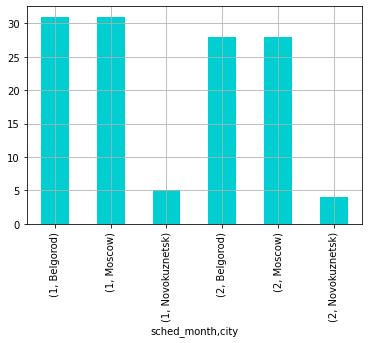

In [214]:
# число рейсов
flight.groupby(by = ['sched_month', 'city'])['flight_profit'].count().plot(kind = 'bar', grid= True, color = '#00CED1')

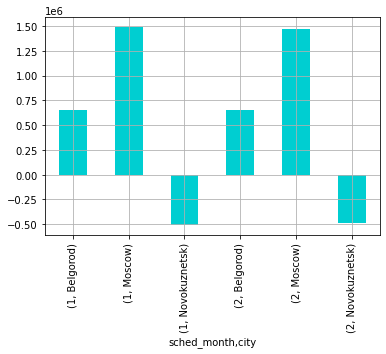

In [215]:
# средняя прибыль по городам с группировкой по месяцам
flight.groupby(by = ['sched_month', 'city'])['flight_profit'].mean().plot(kind = 'bar', grid= True, color = '#00CED1')

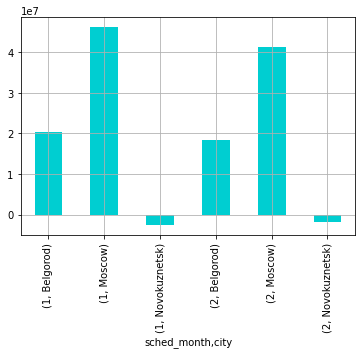

In [216]:
# суммарная прибыль по рейсам с группировкой по месяцам
flight.groupby(by = ['sched_month', 'city'])['flight_profit'].sum().plot(kind = 'bar', grid= True, color = '#00CED1')

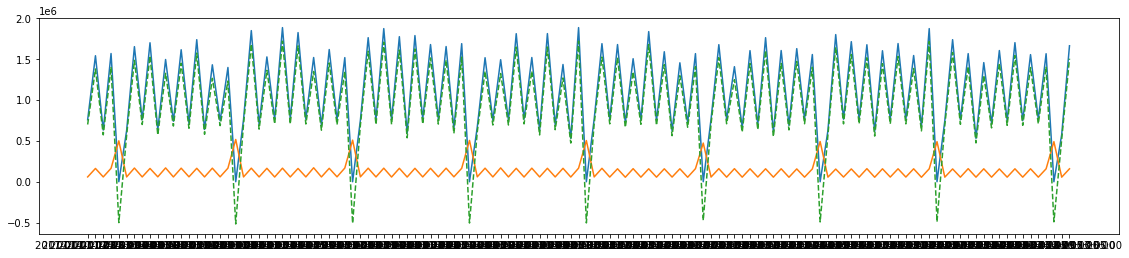

In [222]:
fig = plt.figure(figsize=(15, 3))
axes = fig.add_axes([0,0,1,1])
axes.plot(flight['scheduled_departure'], flight['total_amount']) 
axes.plot(flight['scheduled_departure'], flight['flight_costs'], linestyle='-') 
axes.plot(flight['scheduled_departure'], flight['flight_profit'], linestyle='--')

In [185]:
# исппользуем из датасета только часть полей для анализа
fl = flight[['flight_id', 'sched_month', 'flight_no', 'flight_duration', 'city',
        'aircraft_code', 'total_amount', 'flight_hour', 'flight_costs', 'flight_profit' ]]

fl.sample(5)

,flight_id,sched_month,flight_no,flight_duration,city,aircraft_code,total_amount,flight_hour,flight_costs,flight_profit
23,136366,1,PG0252,01:39:00,Moscow,733,1527400,1.650,164082.6000,1363317
79,136514,2,PG0194,04:59:00,Novokuznetsk,733,0,4.983,473022.2376,-473022
47,136767,1,PG0480,00:51:00,Belgorod,SU9,651300,0.850,59873.5750,591426
24,136758,1,PG0480,00:49:00,Belgorod,SU9,765300,0.817,57549.0715,707750
48,136293,1,PG0252,01:39:00,Moscow,733,1689600,1.650,164082.6000,1525517


In [186]:
len(fl.columns), fl.columns

(10,
 Index(['flight_id', 'sched_month', 'flight_no', 'flight_duration', 'city',
        'aircraft_code', 'total_amount', 'flight_hour', 'flight_costs',
        'flight_profit'],
       dtype='object'))

In [187]:
fl.groupby(['city'])['total_amount'].sum()

city
Belgorod        41915700
Moscow          96912000
Novokuznetsk           0
Name: total_amount, dtype: int64

In [188]:
fl[fl['total_amount'] <= 0].groupby(['city'])['flight_no'].count()

city
Novokuznetsk    9
Name: flight_no, dtype: int64

In [189]:
# выводим убыточный рейс
fl.query('total_amount <= 0')

,flight_id,sched_month,flight_no,flight_duration,city,aircraft_code,total_amount,flight_hour,flight_costs,flight_profit
4,136546,1,PG0194,05:02:00,Novokuznetsk,733,0,5.033,500501.6520,-500501
19,136523,1,PG0194,05:12:00,Novokuznetsk,733,0,5.200,517108.8000,-517108
34,136540,1,PG0194,05:07:00,Novokuznetsk,733,0,5.117,508854.9480,-508854
49,136560,1,PG0194,05:05:00,Novokuznetsk,733,0,5.083,505473.8520,-505473
64,136544,1,PG0194,05:04:00,Novokuznetsk,733,0,5.067,503882.7480,-503882
79,136514,2,PG0194,04:59:00,Novokuznetsk,733,0,4.983,473022.2376,-473022
94,136567,2,PG0194,05:11:00,Novokuznetsk,733,0,5.183,492007.6776,-492007
109,136511,2,PG0194,05:10:00,Novokuznetsk,733,0,5.167,490488.8424,-490488
124,136513,2,PG0194,05:10:00,Novokuznetsk,733,0,5.167,490488.8424,-490488


In [190]:
# суммарный предпологаемый убыток по рейсу в Новокузнецк
fl.query('flight_no == "PG0194"').groupby('flight_no')['flight_profit'].sum()

flight_no
PG0194   -4481823
Name: flight_profit, dtype: int64

Помечаем себе эти данные для отчета:  
Размер убытка: -4,481 млн руб (либо по данному рейсу нет данных)

### Уберем лишние данные

In [191]:
fl = fl.query('total_amount > 0')
fl.shape

(118, 10)

In [192]:
fl.iloc[fl['flight_profit'].idxmin()]

flight_id            136900
sched_month               2
flight_no            PG0480
flight_duration    00:51:00
city               Belgorod
aircraft_code           SU9
total_amount         765300
flight_hour            0.85
flight_costs        57154.1
flight_profit        708145
Name: 67, dtype: object

In [193]:
fl['flight_profit'].min()

473450

In [194]:
fl['flight_profit'].max()

1720226

### Средняя ожидаемая прибыль по рейсам


In [195]:
# средняя прибыль по рейсам
fl.groupby(['flight_no'])['flight_profit'].mean()

flight_no
PG0252    1.480679e+06
PG0480    6.529121e+05
Name: flight_profit, dtype: float64

In [196]:
# суммарная прибыль по рейсам
fl.groupby(['flight_no'])['flight_profit'].sum()

flight_no
PG0252    87360076
PG0480    38521815
Name: flight_profit, dtype: int64

In [197]:
# средняя прибыль по рейсам и месяцам
fl.groupby(['flight_no', 'sched_month'])['flight_profit'].mean()

flight_no  sched_month
PG0252     1              1.488752e+06
           2              1.471741e+06
PG0480     1              6.530378e+05
           2              6.527730e+05
Name: flight_profit, dtype: float64

In [198]:
fl.query('flight_no == "PG0252"').sample(5)

,flight_id,sched_month,flight_no,flight_duration,city,aircraft_code,total_amount,flight_hour,flight_costs,flight_profit
23,136366,1,PG0252,01:39:00,Moscow,733,1527400,1.650,164082.6000,1363317
113,136165,2,PG0252,01:41:00,Moscow,733,1567600,1.683,159762.4776,1407837
111,136479,2,PG0252,01:39:00,Moscow,733,1738400,1.650,156629.8800,1581770
123,136266,2,PG0252,01:40:00,Moscow,733,1566400,1.667,158243.6424,1408156
100,136268,2,PG0252,01:41:00,Moscow,733,1676200,1.683,159762.4776,1516437


In [199]:
fl.query('flight_no == "PG0480"').sample(5)

,flight_id,sched_month,flight_no,flight_duration,city,aircraft_code,total_amount,flight_hour,flight_costs,flight_profit
101,136620,2,PG0480,00:49:00,Belgorod,SU9,613500,0.817,54935.1617,558564
105,136815,2,PG0480,00:51:00,Belgorod,SU9,765300,0.850,57154.0850,708145
84,136666,2,PG0480,00:50:00,Belgorod,SU9,664500,0.833,56011.0033,608488
71,136672,2,PG0480,00:50:00,Belgorod,SU9,759000,0.833,56011.0033,702988
92,136857,2,PG0480,00:50:00,Belgorod,SU9,765300,0.833,56011.0033,709288


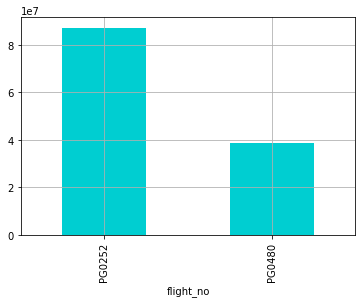

In [211]:
fl.groupby(by = ['flight_no'])['flight_profit'].sum().plot(kind = 'bar', grid= True, color = '#00CED1')

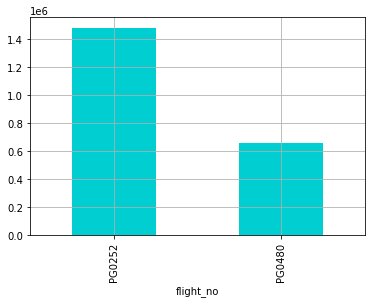

In [223]:
fl.groupby(by = ['flight_no'])['flight_profit'].mean().plot(kind = 'bar', grid= True, color = '#00CED1')

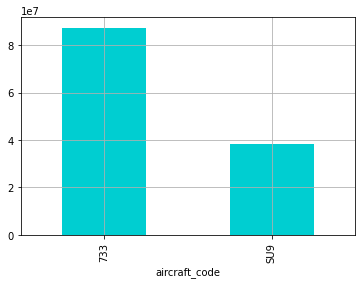

In [224]:
fl.groupby(by = ['aircraft_code'])['flight_profit'].sum().plot(kind = 'bar', grid= True, color = '#00CED1')

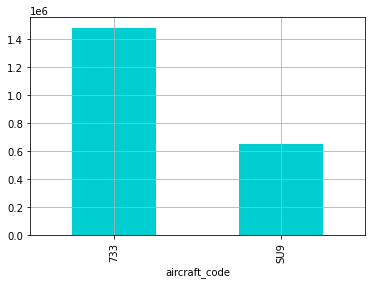

In [225]:
fl.groupby(by = ['aircraft_code'])['flight_profit'].mean().plot(kind = 'bar', grid= True, color = '#00CED1')

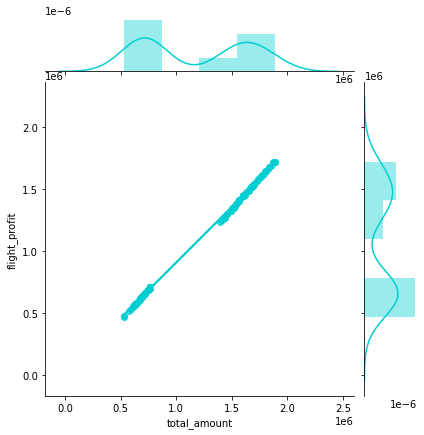

In [226]:
sns.jointplot(x = 'total_amount', y = 'flight_profit', data = fl, kind='reg', color = '#00CED1')

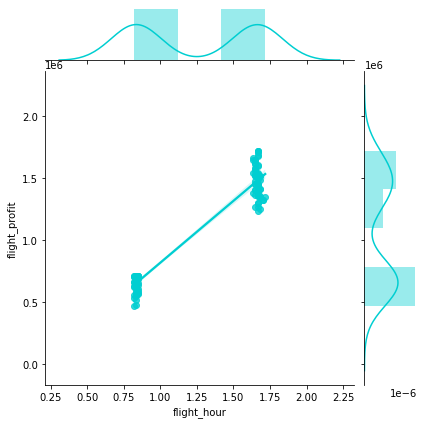

In [227]:
sns.jointplot(x = 'flight_hour', y = 'flight_profit', data = fl, kind='reg', color = '#00CED1')

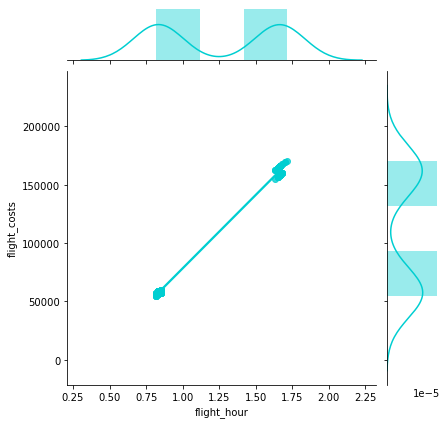

In [210]:
sns.jointplot(x = 'flight_hour', y = 'flight_costs', data = fl, kind='reg', color = '#00CED1')


### Итоги Анализа

**Убыточный рейс PG0194 (Анапа-Новокузнецк)**  
Размер убытка: -4,481 млн руб

Предолагаемая суммарная прибыль по рейсам:
- PG0252(Moscow) = 87,360 млн руб
- PG0480(Belgorod) = 38,521 млн руб

Предолагаемая средняя прибыль по рейсам:
- PG0252(Moscow) = 1,48 млн руб
- PG0480(Belgorod) = 0,65 млн руб


